# Comparing different runs of one experiment
in this note book I want to compare results of different runs of one experiment
it devides into two parts:
1. comparing the evaluation metrics
2. comparing the prediction itself

## dataset info:

.321  train series
.2247 test series

for the last part we have 24(prediction_length) * 2247 = 53,928

## imports

In [58]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [59]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [60]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from gluonts.model.forecast import SampleForecast

## global variable

In [61]:
num_samples = 100

In [62]:
# data_address2 = 'results'  # this is for just 10 results.
# data_address = 'results' # we fixed the seed
# data_address2 = r'D:\ntnu\summer internship\code stuff\results_seed' # this is for 10 fixed seed resutls
data_address = r'D:\ntnu\summer internship\code stuff\results' # this is for 100 resutls

### plot functions

In [63]:
# function to plot the sample forcast of one experiment as well as target value for a specific area
def plot_forscast(sample_forcast_list_val,
                  exp_n_val,
                  sample_n_val,
                  forcast_list_val=None):
    # make the sample object to use gluonts library
    sample_np = sample_forcast_list_val[exp_n_val].iloc[:, sample_n_val : sample_n_val + 24].to_numpy()
    tms = pd.Timestamp(1).now()
    sample_obj = SampleForecast(
            samples=sample_np,
            start_date=tms,
#             )h
            freq='H',
#             item_id=self.item_id,
#             info=self.info,
            )
    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols=2, figsize=(20,10))
    prediction_intervals = (50, 99.99)
    legend = ["median prediction", "mean"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    ax2 = sample_obj.plot(prediction_intervals=prediction_intervals, color='g', show_mean=True)
    # if forcast_list_val is passed, the target will be plotted as well
    if forcast_list_val is not None:
        # extra part
        target_forcast_series = get_forcast_target(forcast_list)
        target_slice = target_forcast_series.iloc[sample_n_val : sample_n_val + 24]
        target_date_range = pd.date_range(tms, periods=len(target_slice), freq='H')
        target_slice.index = target_date_range
        ax2 = target_slice.plot()
    plt.legend(legend, loc="upper left")
    sample_forcast_list_val[exp_n_val].iloc[:, sample_n_val : sample_n_val + 24].T.plot(legend=False, ax=ax1)
    return fig

In [84]:
# plots a same area for all the samples
def plot_forscast_same(sample_forcast_list_val,
                       sample_n_val,
                       lim=10):
    color_list = ['g','b','r','y','cyan', 'orange', 'brown', 'purple', 'pink', 'gray']
    for idx, sample_el in enumerate(sample_forcast_list_val):
        # check if we have more than 10 diagrams
        if idx >= lim:
            break
        sample_np = sample_el.iloc[:, sample_n_val : sample_n_val + 24].to_numpy()
        tms = pd.Timestamp(1).now()
        sample_obj = SampleForecast(
                samples=sample_np,
                start_date=tms,
                freq='H',
                )
        prediction_intervals = (25, 50)
        legend = ["median prediction", "mean"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
        sample_obj.plot(prediction_intervals=prediction_intervals, color=color_list[idx], show_mean=True)
    plt.legend(legend, loc="upper left")
    plt.show()

In [65]:
# this is the plot function we call which uses plot_forcast to plot multiple plots and save the results
def save_plot_exp(exp_lim, sample_n):
    for idx in range(exp_lim):
        a=plot_forscast(sample_forcast_list, idx, sample_n)
        a.savefig(f'plots/result_sample{sample_n}_exp{idx}')

### Dataloading functions

read each metrics as a dataframe first

In [66]:
def read_csv_result(result_type, address, n_files=None):
    rootdir = address
    os.path.isdir(rootdir)

    df_list = []
    filenames = []

    for subdir, _, files in tqdm(os.walk(rootdir)):
        filenames += [os.path.join(subdir, file) for file in files if file == result_type]

    if n_files is not None:
        filenames = filenames[:n_files]
        
    for filename in tqdm(filenames, ascii=True, ncols=50):
        df = pd.read_csv(filename)
        df_list.append(df)
        
    return df_list

### metrics function

In [67]:
# it returns a dataframe of metrics of all test datas for all the experiements

def get_metric_df(metric_list_val, metric_name = 'MAPE'): 
    metric_df_list = []
    # number of testseries
    test_set_len = metric_list_val[0].shape[0]
    
    # number of experiments we did
    exp_len = 0
    # we need to set a name for it
    for metrics_experiment in metric_list_val:
        exp_len += 1
        current_mse_series = metrics_experiment[metric_name]
        current_mse_series.name = f'rep_{exp_len}'
        metric_df_list.append(current_mse_series)
    metric_dataframe = pd.concat(metric_df_list, axis=1).T
    return metric_dataframe

In [68]:
# plots limited number of elements of list of dataframes
def plot_df_list(sample_forcast_list_val, no_plot = 5):
    for i, forcast_el in enumerate(sample_forcast_list_val):
        if i > no_plot:
            break
        forcast_el[0].plot()

### forcast function

In [69]:
# returns list of all dfs with only samples column
def get_forcast_samples(forcast_list_val):
    num_exp = len(forcast_list_val)
    
    # get just samples columns
    sample_forcast_list_val = []
    for forcast_el_val in forcast_list_val:
        sample_forcast_list_val.append(forcast_el_val.loc[:, 'sample0':f'sample{num_samples-1}'].T)
    return sample_forcast_list_val

In [70]:
# returns list of all dfs with only samples column
def get_forcast_distrib(forcast_list_val):
    num_exp = len(forcast_list_val)
    
    # get just samples columns
    distrib_forcast_list = []
    for forcast_el_val in forcast_list_val:
        # first get the samples
        sample_forcast_elm = forcast_el_val.loc[:, 'sample0':f'sample{num_samples-1}'].T
            
        mean  = sample_forcast_elm.mean()
        sigma = sample_forcast_elm.std(ddof=1)
        forcast_distrib_dict = {'mean' : mean, 'sigma' : sigma} 
        forcast_distrib_df = pd.DataFrame(forcast_distrib_dict).T
        forcast_distrib_df
        distrib_forcast_list.append(forcast_distrib_df)
    return distrib_forcast_list

In [71]:
# returns list of all dfs with only samples column
def get_forcast_distrib_sample(sample_forcast_list_val):
    num_exp = len(sample_forcast_list_val)
    
    # get just samples columns
    distrib_forcast_list = []
    for sample_forcast_elm in sample_forcast_list_val:
        mean  = sample_forcast_elm.mean()
        sigma = sample_forcast_elm.std(ddof=1)
        forcast_distrib_dict = {'mean' : mean, 'sigma' : sigma} 
        forcast_distrib_df = pd.DataFrame(forcast_distrib_dict).T
        forcast_distrib_df
        distrib_forcast_list.append(forcast_distrib_df)
    return distrib_forcast_list

In [72]:
# outputs numpy 3d array of shape [num_exp, num_samples, num_test * prediction_length]
def get_np_forcast(sample_forcast_list_val):
    num_exp = len(sample_forcast_list_val)
    forcast_np = np.zeros((num_exp,*sample_forcast_list_val[0].shape))
    for idx in range(num_exp):
        forcast_np[idx] = sample_forcast_list_val[idx].to_numpy()
    return forcast_np

In [73]:
# calculate the std of 3d np array, shape of output = [num_samples, num_test * prediction_length]
def get_std_np(forcast_np, sample_forcast_list_val):
    forcast_std_np = np.zeros(sample_forcast_list_val[0].shape)
    for idx in range(forcast_np.shape[-1]):
        forcast_std_np[:,idx] = forcast_np[:,:,idx].std(axis = 0)
    return forcast_std_np

In [74]:
# returns the target serie
def get_forcast_target(forcast_list):
    return forcast_list[0].loc[:, 'target'].T

### quantile filter functions

In [75]:
# get the interval of 0.25 to 0.75 quantile of sample forcast
def make_50ps_intervals(sample_forcast_list_element_val):
    my_df1 = sample_forcast_list_element_val
    q11 = my_df1.quantile(0.25)
    q21 = my_df1.quantile(0.75)
    mask1 = (my_df1 < q21) & (q11 < my_df1)
    return my_df1[mask1]

In [76]:
# make a list of 50% intervals
def make_50ps_interval_list(sample_forcast_list_val, list_lim=None):
    quantile_sample_list = []
    
    if list_lim is not None:
        sample_forcast_list_val = sample_forcast_list_val[:list_lim]
        
    for sample_forcast_list_element in sample_forcast_list_val:
        quantile_sample_list.append(make_50ps_intervals(sample_forcast_list_element))
    return quantile_sample_list

## ks test

In [104]:
def kss_test(sample_forcast_list_val, exp_lim, timepoint_lim_val):
    # initialze the tables with 0
    ks_statistic_table = np.zeros((timepoint_lim_val, exp_lim, exp_lim))
    ks_pvalue_table = np.zeros((timepoint_lim_val, exp_lim, exp_lim))
    
    # for all the timepoints
    for timepoint_el in tqdm(range(timepoint_lim_val)):
        # for all the experiments,
        for exp_n in range(exp_lim):
            for idx in range(exp_n,exp_lim):
                smpl1 = sample_forcast_list_val[exp_n][timepoint_el]
                smpl2 = sample_forcast_list_val[idx][timepoint_el]
                res = stats.ks_2samp(smpl1, smpl2)
                ks_statistic_table[timepoint_el,exp_n,idx] = res.statistic
                ks_pvalue_table[timepoint_el,exp_n,idx] = res.pvalue
    
    return ks_statistic_table, ks_pvalue_table

# metrics

In [77]:
# loop through all the experiments in the results folder and read the metric dataframe
metrics_list = read_csv_result('metrics.csv', data_address)

101it [00:00, 286.43it/s]
100%|###########| 100/100 [00:02<00:00, 45.87it/s]


In [78]:
metrics_list[2]

,Unnamed: 0,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,0.0,208.957703,295.727661,235.0,9.791667,8.031874,1.534136,2.977840,0.815617,NaN,32.896197,274.819475,0.791667,295.727691,0.958333,95.301715,1.000000
1,1,1.0,28.347422,107.270920,2499.0,104.125000,9.577165,0.466696,0.042488,0.041935,NaN,2.246822,43.929463,0.000000,107.270920,0.625000,59.357831,1.000000
2,2,2.0,0.263887,10.669859,190.0,7.916667,8.673073,0.051260,0.057057,0.055210,NaN,0.280863,4.310646,0.000000,10.669859,0.750000,7.381905,1.000000
3,3,3.0,1387.989258,592.448975,10468.0,436.166667,48.398763,0.510041,0.052506,0.055069,NaN,5.768681,289.112958,0.000000,592.448975,0.166667,311.947968,0.791667
4,4,4.0,210.932943,249.445145,4087.0,170.291667,25.383302,0.409464,0.056508,0.058224,NaN,4.454742,116.711958,0.041667,249.445145,0.333333,136.877130,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2242,316.0,916.448730,605.616943,6671.0,277.958333,30.914619,0.816249,0.205472,0.171448,NaN,12.725881,357.573476,0.416667,605.616913,0.583333,306.975716,0.875000
2243,2243,317.0,256.661194,251.205414,1058.0,44.083333,31.192686,0.335556,0.217436,0.220784,NaN,7.472598,87.377694,0.208333,251.205416,0.375000,235.769146,0.583333
2244,2244,318.0,126413.520833,7298.220703,50192.0,2091.333333,267.793565,1.135548,0.147961,0.144262,NaN,25.990475,4802.034497,0.250000,7298.221191,0.416667,4656.357129,0.500000
2245,2245,319.0,8491.295573,1610.291016,10581.0,440.875000,169.860660,0.395003,0.134414,0.145932,NaN,8.171546,534.137015,0.000000,1610.291031,0.083333,1470.571109,0.500000


In [23]:
# now get the list of mse series

In [25]:
metric_name = 'MASE'
metric_df = get_metric_df(metrics_list, metric_name)
metric_df

,0,1,2,3,4,5,6,7,8,9,...,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246
rep_1,1.362157,0.473692,0.039341,0.501122,0.405557,0.419757,0.376686,0.500206,0.568945,0.792300,...,1.146327,1.152045,2.455401,1.127242,0.787675,0.644554,0.332376,1.127008,0.523793,0.864510
rep_2,1.551399,0.421512,0.043682,0.738652,0.499917,0.425631,0.382332,0.613228,0.620828,0.696401,...,1.026437,1.238960,2.841552,1.291922,1.037403,0.697897,0.343327,1.240961,0.433498,1.025999
rep_3,1.534136,0.466696,0.051260,0.510041,0.409464,0.415905,0.348478,0.550666,0.589256,0.756818,...,1.043241,1.363592,3.167867,1.416720,1.113176,0.816249,0.335556,1.135548,0.395003,0.892607
rep_4,1.460687,0.654038,0.056585,0.971093,0.688745,0.524036,0.594669,0.736586,0.748109,0.723086,...,1.058358,1.339346,2.990768,1.437138,1.390688,0.769509,0.369608,1.268158,0.585173,1.251573
rep_5,1.774860,0.412734,0.039651,0.584394,0.457445,0.340581,0.509772,0.516060,0.572755,0.679824,...,1.135574,0.926284,2.314072,1.075620,0.771037,0.554573,0.307428,1.115760,0.384393,0.780017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rep_96,1.546469,0.535653,0.049877,0.474387,0.379951,0.434073,0.360749,0.545350,0.572841,0.754013,...,1.201133,1.162436,2.380284,1.261965,0.640036,0.777270,0.312416,1.043198,0.313080,0.731934
rep_97,1.447182,1.397664,0.215451,1.280813,1.049025,0.619923,1.112571,0.764561,0.917571,0.763015,...,1.143265,1.423861,3.076963,1.311622,1.220249,0.942384,0.460759,1.247499,0.512656,1.239038
rep_98,1.333757,1.330400,0.096352,1.594968,1.095065,1.057586,0.679143,1.348266,0.972583,0.793524,...,1.560439,1.916487,3.671566,1.951670,2.012411,1.219631,0.383139,1.553433,0.625330,2.013725
rep_99,1.556277,0.601759,0.078043,0.428352,0.409627,0.441879,0.306049,0.541521,0.565646,0.796082,...,1.117332,1.215535,2.881713,1.261675,0.875014,0.763909,0.349167,1.127446,0.384986,0.864741


Now I will calculate the std of MSE using online calculator

from exp1 to 10

first I get the MSE value for test dataset #1 by reading the csv file manually:
    189.5191447, 223.2694092, 251.8757121, 204.6587118, 224.1667684, 210.6158447,165.0758464, 114.8061117, 170.1800944, 167.7697754

then using an online calculator calculated the STD here is the response:
    Standard deviation (s): 39.238824715093
    

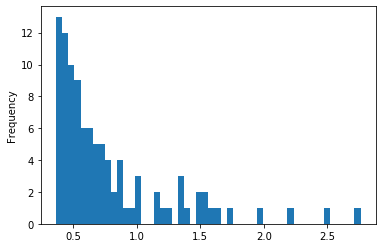

In [26]:
metric_df[1].plot.hist(bins = 50)

In [27]:
std_metric = metric_df.std()
std_metric

0       0.167786
1       0.474857
2       0.052434
3       0.419636
4       0.303100
          ...   
2242    0.256248
2243    0.042696
2244    0.153974
2245    0.128168
2246    0.414388
Length: 2247, dtype: float64

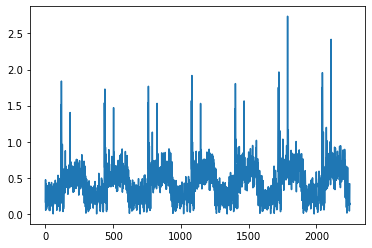

In [28]:
std_metric.plot()

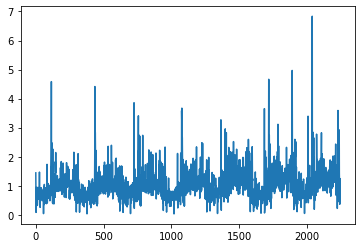

In [29]:
metric_df.mean().plot()

# forcast

In [31]:
# read the forcast file
forcast_list = read_csv_result('forcasts.csv', data_address)

101it [00:00, 7788.65it/s]
100%|###########| 100/100 [02:50<00:00,  1.71s/it]


In [32]:
len(forcast_list)

100

In [33]:
target_forcast_series = get_forcast_target(forcast_list)

In [34]:
# get the sample columns
sample_forcast_list = get_forcast_samples(forcast_list)
sample_forcast_list[0]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
sample0,14.379720,11.616039,17.561302,24.004303,18.771730,20.312325,21.459580,22.115059,22.725494,24.404095,...,3408.1184,3759.9140,3618.0034,3362.8606,3411.2124,4066.0178,3844.4490,3932.6667,2425.3064,3405.9153
sample1,17.195013,26.078800,20.301533,21.817753,23.281832,19.998745,16.863081,23.405290,24.261312,47.478947,...,3444.2990,3287.6626,3331.0970,3591.5090,3761.8674,3712.7520,3338.7993,3530.4812,3588.4521,3210.2870
sample2,16.816391,21.088438,19.986979,22.116865,22.229113,26.031810,23.707888,23.367422,20.343147,8.893280,...,3339.6690,3812.4983,3678.6233,3817.3765,3806.9119,3770.0610,3266.0083,3617.7220,3477.5203,3182.5225
sample3,15.426297,18.665880,20.580153,23.141403,22.790546,23.731490,21.891476,24.997192,23.367510,18.879694,...,3432.6882,3657.4570,3670.8794,3624.2625,3461.4426,3734.4520,3494.7974,3522.9685,3585.2444,3560.1904
sample4,15.173604,23.618174,30.532934,25.938190,23.521881,23.635962,20.457691,27.114605,22.730186,23.462740,...,3643.1138,3311.5684,3577.6096,3537.3958,3534.1968,3869.1630,3872.8179,3852.6926,3879.6248,3374.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,11.198023,19.059963,12.375492,21.178700,22.414312,22.261217,21.918068,21.585732,24.703676,22.924610,...,3018.1310,3359.5176,3406.8262,3628.7104,3370.5579,3478.3875,3928.0195,3670.4930,3508.7998,3460.6663
sample96,17.758795,24.776709,18.558569,24.110640,22.177675,21.200571,21.345118,27.829294,18.730286,14.706315,...,3188.7727,3238.4336,3290.6106,3358.4546,3152.2263,3553.5940,3748.1262,3536.4768,3610.4976,3387.1467
sample97,16.044125,18.216288,20.252241,22.964743,20.309752,22.060461,26.719416,21.965384,21.311255,19.750475,...,3275.0583,3374.2007,3625.7039,3318.7456,3533.9731,3590.5808,3940.9727,3772.5212,3631.6562,3339.9790
sample98,7.908178,20.053026,6.758836,21.839102,18.221664,21.016320,22.907060,17.935090,21.467836,22.911772,...,3342.6125,2249.2913,3463.4194,3174.4130,3466.1526,3700.0361,3694.1710,3666.0256,3541.6296,3463.9866


I want to see how does samples look like here

### kernel density estimation

idx sets the row of plot
first column is histogram of samples
second column is kernel density estimation

each experiment has been done on all the (53927) time points. we plot the distribution of samples for some experiments.
we plot num_shapes number of diagrams, basically it means we plot the first num_shapes experiemtns.


Text(0.5, 0.98, ' experiment #2, dataset #[0, 120, 53927], KDE')

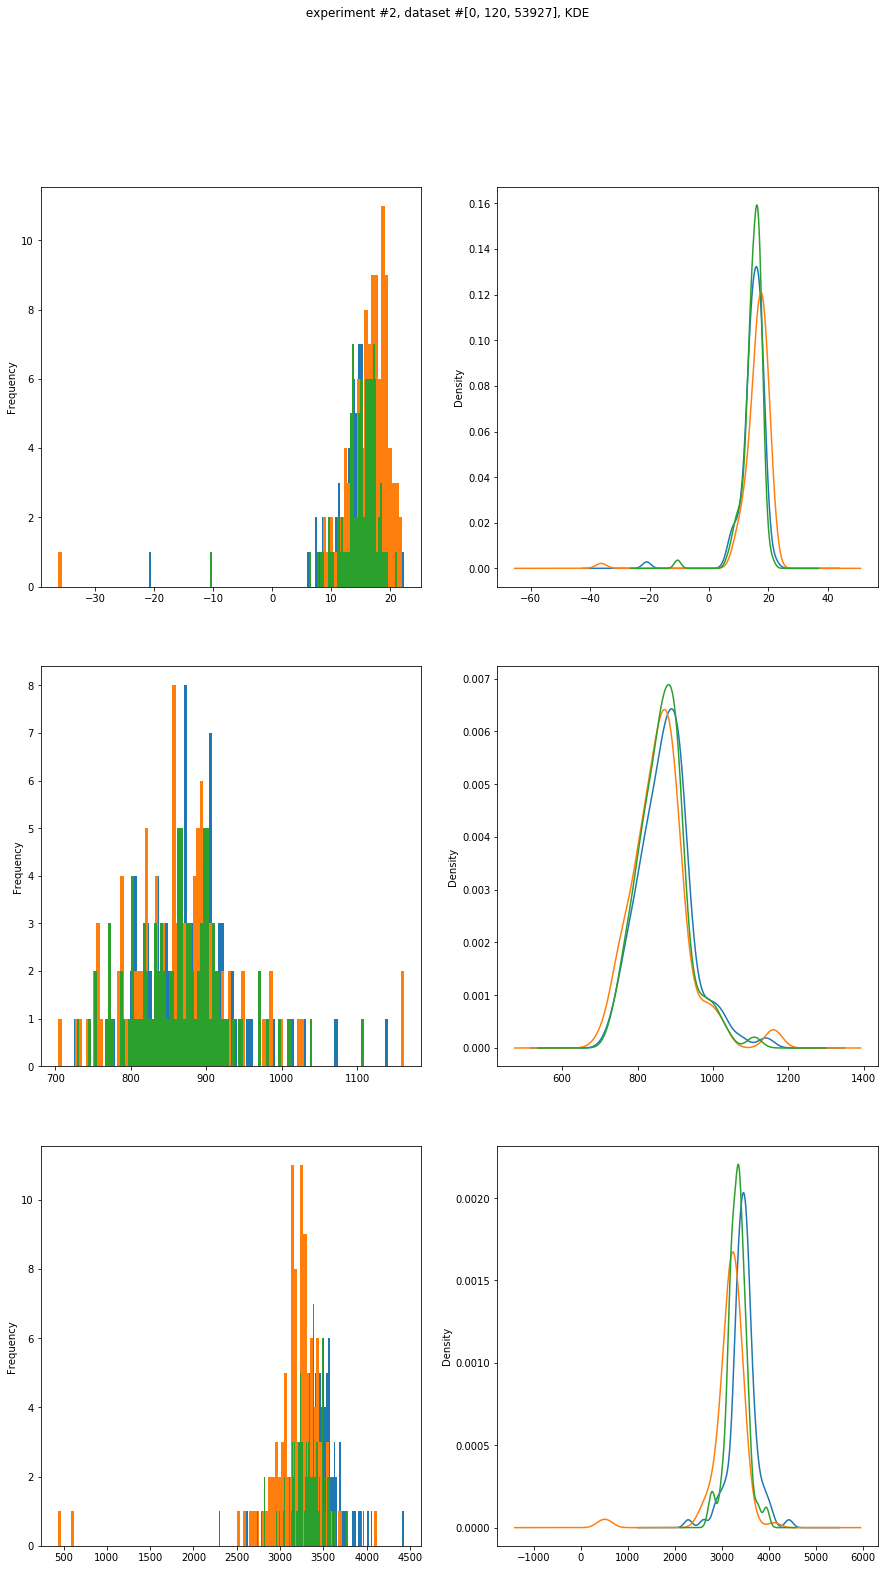

In [35]:
exp_n = 0
data_n = [0, 120, 53927]
num_shapes = 3
fig, ax1 = plt.subplots(nrows = len(data_n), ncols=2, figsize=(15,25))

for idx, data_n_el in enumerate(data_n):
    for exp_n in range(num_shapes):
        sample_forcast_list[exp_n][data_n_el].plot.hist(bins = 100, ax=ax1[idx,0])
        sample_forcast_list[exp_n][data_n_el].plot.kde(0.3, ax=ax1[idx,1])

fig.suptitle(f' experiment #{exp_n}, dataset #{data_n}, KDE')

### histogram of simples

Text(0.5, 1.0, ' experiment #4, dataset #53918, KDE')

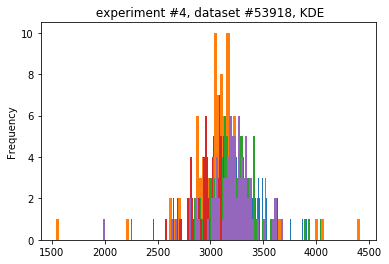

In [36]:
exp_n = 0 
data_n = 53918
for exp_n in range(5):
    sample_forcast_list[exp_n][data_n].plot.hist(bins = 100)
#     sample_forcast_list[exp_n][data_n].plot.kde()
plt.title(f' experiment #{exp_n}, dataset #{data_n}, KDE')

Calculate manually to see if the function works well

In [37]:
mean  = sample_forcast_list[0].mean()
sigma = sample_forcast_list[0].std()
forcast_distrib_dict = {'mean' : mean, 'sigma' : sigma} 
forcast_distrib_df = pd.DataFrame(forcast_distrib_dict).T
forcast_distrib_df

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
mean,14.761161,22.945884,21.714087,23.258253,23.111719,23.527661,21.356013,22.152550,23.225393,22.002890,...,3290.425475,3444.414715,3540.978757,3491.214351,3574.830213,3645.678158,3718.893781,3731.761447,3625.962470,3448.757526
sigma,4.685222,9.738503,4.591613,3.083781,2.457431,2.946704,8.144207,4.237471,5.219758,5.592814,...,197.300487,309.321830,240.576437,256.637121,332.303804,343.863176,224.041995,256.105991,233.442736,278.429062


In [38]:
forcast_distrib_df_2 = get_forcast_distrib(forcast_list)
forcast_distrib_df_2[0]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
mean,14.761161,22.945884,21.714087,23.258253,23.111719,23.527661,21.356013,22.152550,23.225393,22.002890,...,3290.425475,3444.414715,3540.978757,3491.214351,3574.830213,3645.678158,3718.893781,3731.761447,3625.962470,3448.757526
sigma,4.685222,9.738503,4.591613,3.083781,2.457431,2.946704,8.144207,4.237471,5.219758,5.592814,...,197.300487,309.321830,240.576437,256.637121,332.303804,343.863176,224.041995,256.105991,233.442736,278.429062


In [39]:
forcast_distrib_df_2[9]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
mean,17.577718,27.051038,26.608576,28.053724,25.212760,24.760167,19.491801,19.268827,19.612249,19.099956,...,3412.263556,3555.865115,3670.428233,3675.466681,3700.768733,3807.724860,3892.602772,3876.945045,3773.774187,3619.809770
sigma,6.742118,13.780943,6.378505,4.383600,2.547206,2.517257,6.216718,3.859891,4.039177,4.416588,...,206.576788,287.705473,282.064653,277.266354,213.178485,308.031609,334.388858,257.629383,213.715963,224.257792


Now I will check
1. sigma of 53927-6 of first csv file manually
2. sigma of means and sigmas in point 53927

the answer is:
1. in case of std. for 6=286.204316    for 7=250.7138772.   in case of avg. for 6=3550.682522, for 7=3379.849643
2. for mean it was: 201.9734532878



### plot of sigma over time

30641

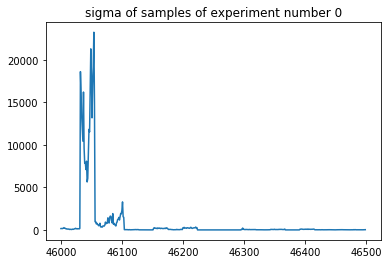

In [40]:
exp_num = 0
forcast_distrib_df_2[exp_num].loc['sigma'][46000:46500].plot()
plt.title(f'sigma of samples of experiment number {exp_num}')
forcast_distrib_df_2[exp_num].loc['sigma'].idxmax()

below is the plot of value of value of samples for a single time point

18616.539408313227

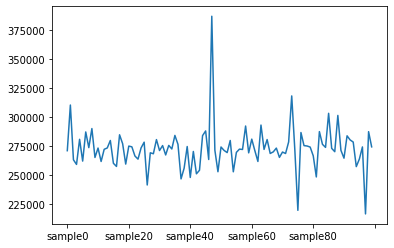

In [41]:
sample_forcast_list[0][38328+7704].plot()
forcast_distrib_df_2[exp_num].loc['sigma'][38328+7704]

My interpretation of seasonality is that since we have 321 dataset which are used to make 7*321 testsets. so we have 7 seasons

In [42]:
# convert the list of dataframes to a 3d np
forcast_np = get_np_forcast(forcast_distrib_df_2)

[ number of experiments, mean and std, number of time points ]

In [43]:
forcast_np.shape

(100, 2, 53928)

In [44]:
# get std over different experiments
forcast_std_np = get_std_np(forcast_np, forcast_distrib_df_2)

In [45]:
forcast_std_np.shape

(2, 53928)

In [46]:
# change it to pandas
df_std_forcast = pd.DataFrame(forcast_std_np)

## note about the dataset: 
cul 0 to 24 is for time series number 0
the last one is for number 320

the further we proceed, we go more and more into the future.

In [47]:
df_std_forcast.rename(index={0:'mean',1:'sigma'}, inplace=True)
df_std_forcast

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
mean,1.456205,2.242264,2.178647,2.065511,2.282157,2.270610,2.011109,2.013775,1.915136,1.974561,...,188.651014,196.270179,203.255717,204.355202,206.945365,210.244221,214.669200,219.079365,216.648398,221.283900
sigma,3.096828,9.025018,2.446077,2.022185,1.130348,1.308043,3.455848,1.363145,1.147719,0.902634,...,66.240863,71.907585,69.158710,57.843379,72.549489,66.198003,89.578699,59.015864,59.951770,77.213764


### how std of the data changes

now here is how the std is changing

Text(0.5, 1.0, 'std of std for all the datapoints')

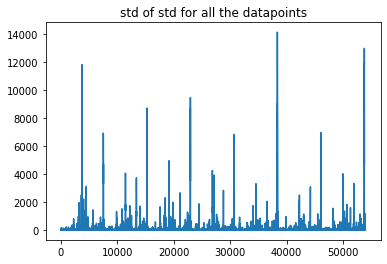

In [48]:
df_std_forcast.loc['sigma'].plot()
plt.title('std of std for all the datapoints')

Text(0.5, 1.0, 'std of mean for all the datapoints')

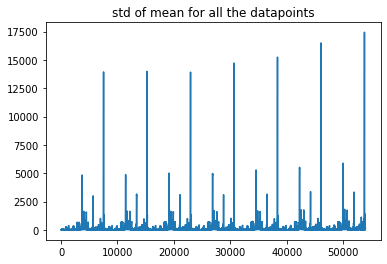

In [49]:
df_std_forcast.loc['mean'].plot()
# plt.xlim([50000, 53927])
plt.title('std of mean for all the datapoints')

plot the std of means in the spikes with target value

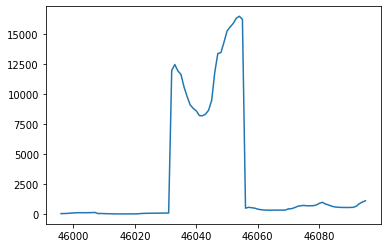

In [50]:
df_std_forcast.loc['mean'].idxmax()
df_std_forcast.loc['mean'][53700-7704:53800-7704].plot()

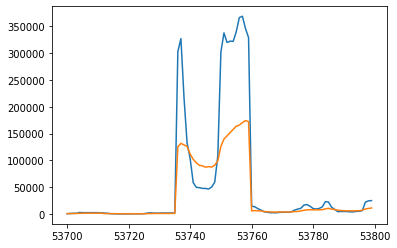

In [51]:
i = 0
target_forcast_series[(53700 - i*7704):(53800 - i*7704)].plot()
(df_std_forcast.loc['mean'][(53700 - i*7704):(53800 - i*7704)] * 10).plot()

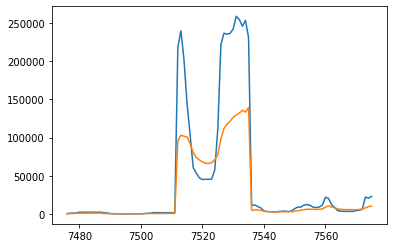

In [52]:
i = 6
target_forcast_series[(53700 - i*7704):(53800 - i*7704)].plot()
(df_std_forcast.loc['mean'][(53700 - i*7704):(53800 - i*7704)] * 10).plot()

## check also statistic function

it seems like numpy std function, does not give us 0 when we have an array of constant values,
lets say 
1. [3335.554543, 3335.554543. 3335.554543] = 0
2. but [3335.554543, 3335.554543, 3335.554543, 3335.554543, 3335.554543] = 4e-13

it also happens ant websites like: calculator.net , calculatorsoup.com

In [53]:
import statistics

equal = forcast_np[0] == forcast_np[1]
last_std_statistics = forcast_np[0][0]
# equal
# last value of the mean of all the experiments
sample=forcast_np[:,0,-9]

statistics.stdev(sample), np.std(forcast_np[:,0], axis=0), np.std(sample, dtype=float)
# sample

(197.25895164252228,
 array([  1.45620455,   2.24226359,   2.17864725, ..., 219.07936513,
        216.64839757, 221.28389962]),
 196.27017874113193)

### get the target value

In [54]:
target_forcast_series

0           9.0
1          10.0
2          22.0
3          20.0
4          13.0
          ...  
53923    4209.0
53924    4120.0
53925    3951.0
53926    3907.0
53927    3814.0
Name: target, Length: 53928, dtype: float64

#### want to check if target is between mean+-sigma of the samples or not for all of the experimetns

In [ ]:
exp_num = 0
series_mean_exp = forcast_distrib_df_2[exp_num].loc['mean']
series_sigma_exp = forcast_distrib_df_2[exp_num].loc['sigma']

In [ ]:
series_sigma_exp, series_mean_exp

In [ ]:
(series_mean_exp + series_sigma_exp), (series_mean_exp - series_sigma_exp)

In [ ]:
correct_predict = ((series_mean_exp + series_sigma_exp) > target_forcast_series) & ((series_mean_exp - series_sigma_exp) < target_forcast_series)

In [ ]:
correct_predict.value_counts()

In [ ]:
def compare_predictions(target_forcast_series,forcast_distrib_df_2):
    correct_predict_list = []
    for forcast_el in forcast_distrib_df_2:
        series_mean_exp = forcast_el.loc['mean']
        series_sigma_exp = forcast_el.loc['sigma']
        correct_predict = ((series_mean_exp + series_sigma_exp) > target_forcast_series) & ((series_mean_exp - series_sigma_exp) < target_forcast_series)
        correct_predict_list.append(correct_predict)
    return correct_predict_list

In [ ]:
correct_predict_list = compare_predictions(target_forcast_series, forcast_distrib_df_2)

In [ ]:
correct_predict_list[0].value_counts()

In [ ]:
exp_num = 0
correct_predict_list[0].astype(float).plot()
plt.xlabel('data point')
plt.ylabel('is in the bound or not?')
plt.title(f'how many prediction of experiment {exp_num} is in (mean +- sigma) boundary')
plt.xlim(1000,1200)

In [ ]:
correct_predict_list[0]

In [ ]:
# try to group them based on time series, next step can be cardinality 

In [ ]:
lim = 20
for i in range(lim):
    df_std_forcast.loc['mean'][i*24:(i+1)*24].plot()
# plt.xlim([50000, 53927])
plt.title(f'std of mean of {lim} time series')
plt.xlabel('time point')
plt.ylabel('std of mean')

In [ ]:
lim = 20
df_std_forcast.loc['mean'][0:lim*24].plot()
plt.xlabel('time point')
plt.ylabel('std of mean')
# plt.xlim([50000, 53927])
plt.title(f'std of mean of {lim} time series')

# plot the predictions of the last experiment here

plot all the experiments with different color

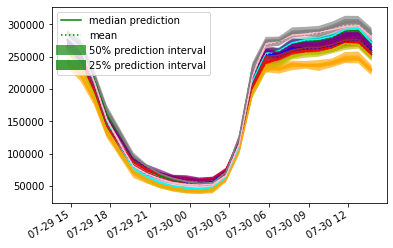

In [85]:
tmp_n = 53736
plot_forscast_same(sample_forcast_list, tmp_n)

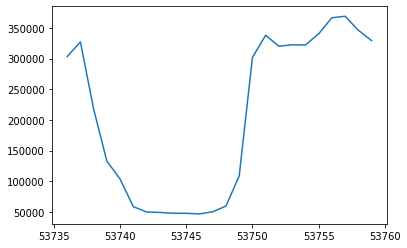

In [86]:
sample_n = 53736
target_forcast_series.iloc[sample_n : sample_n + 24].plot()

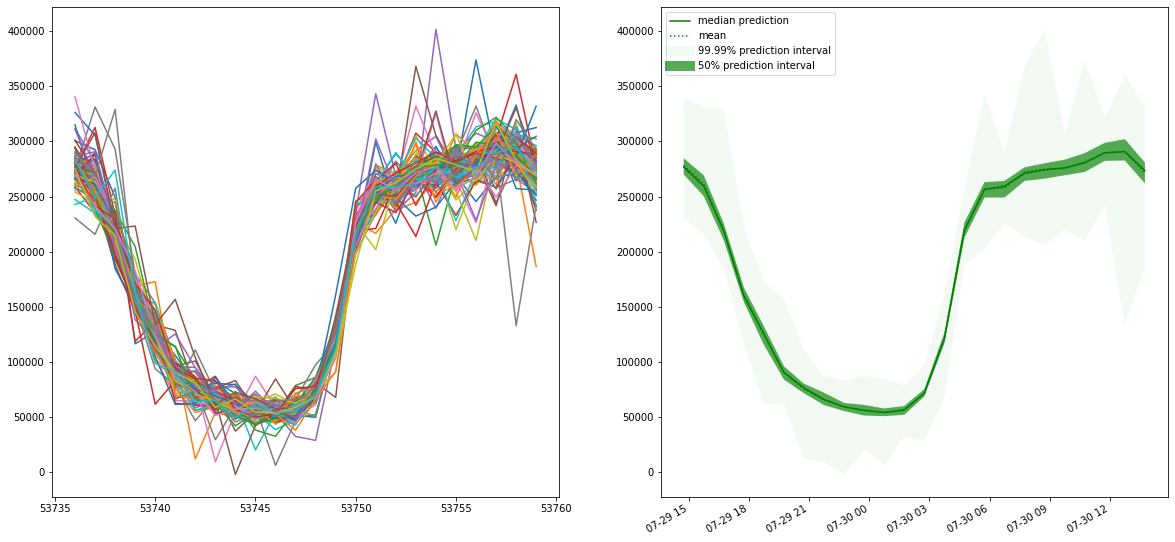

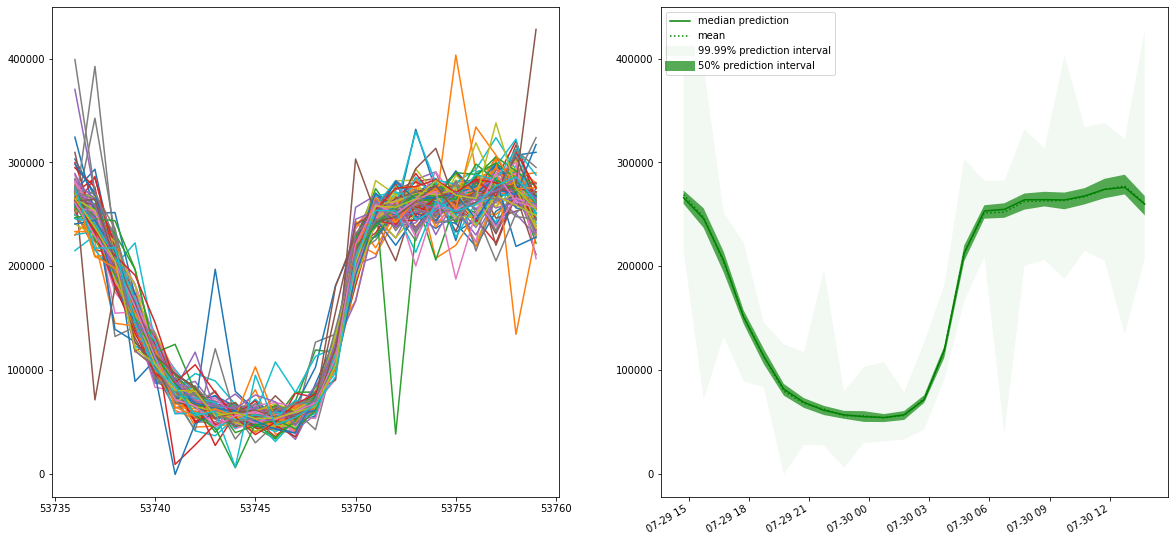

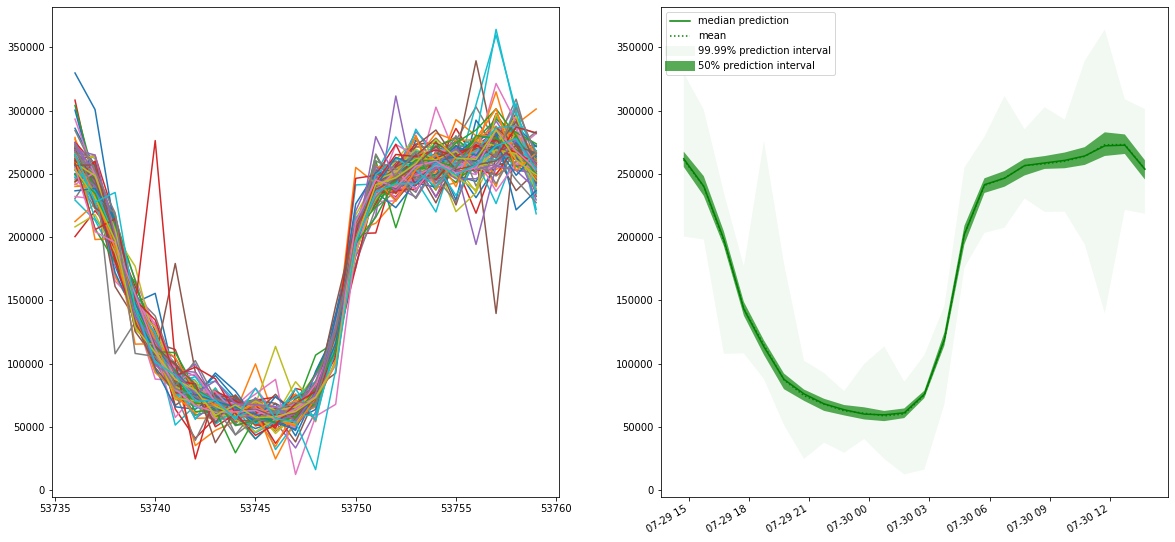

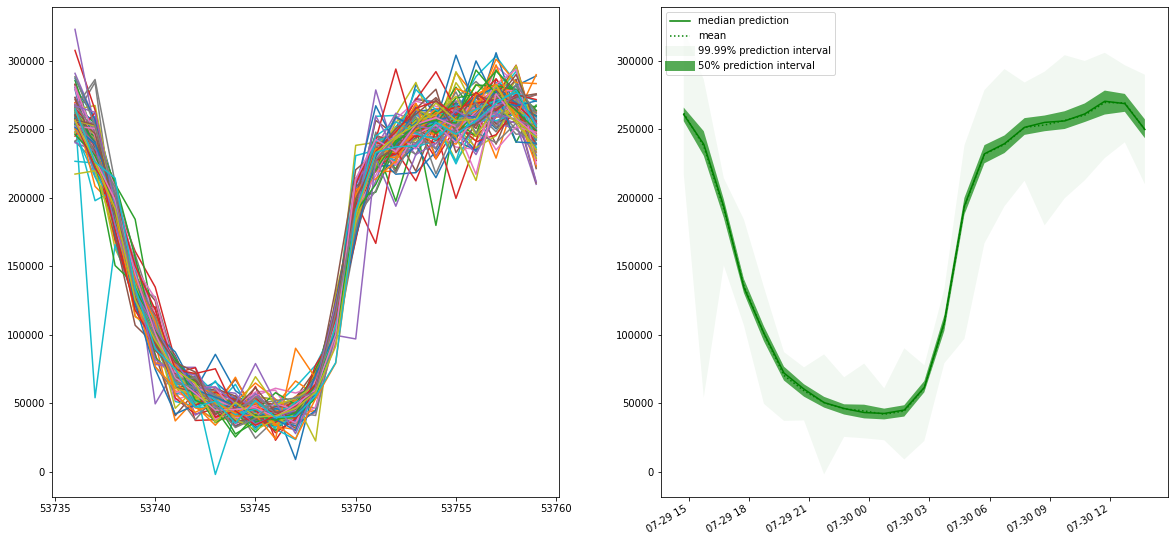

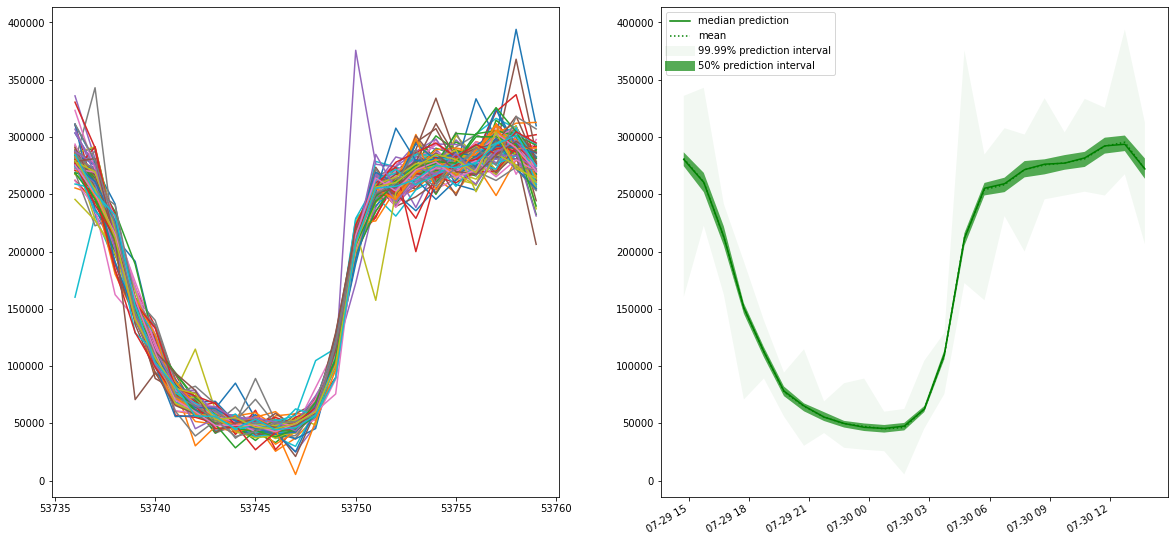

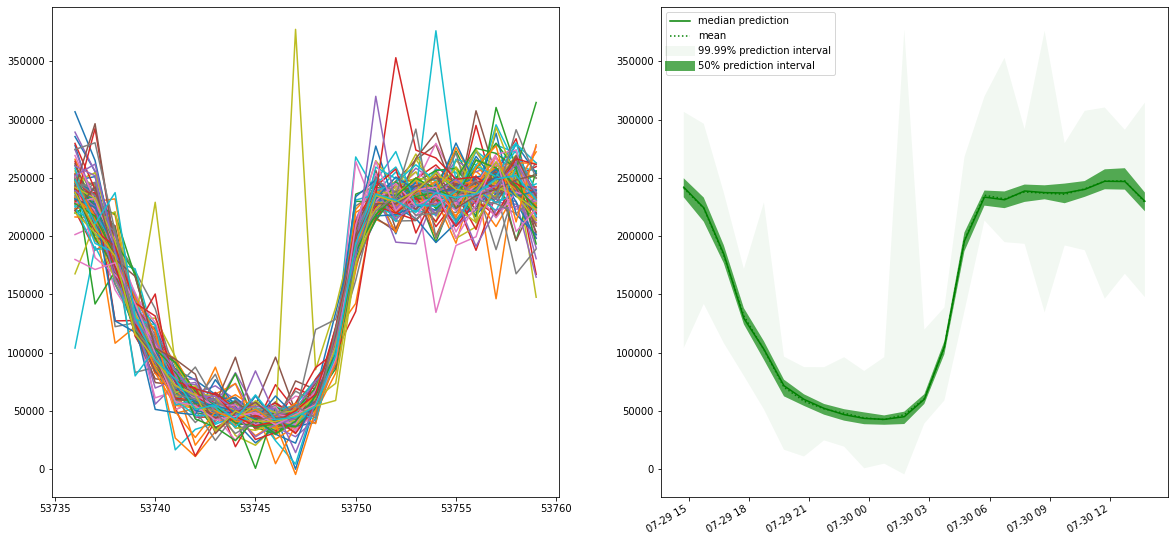

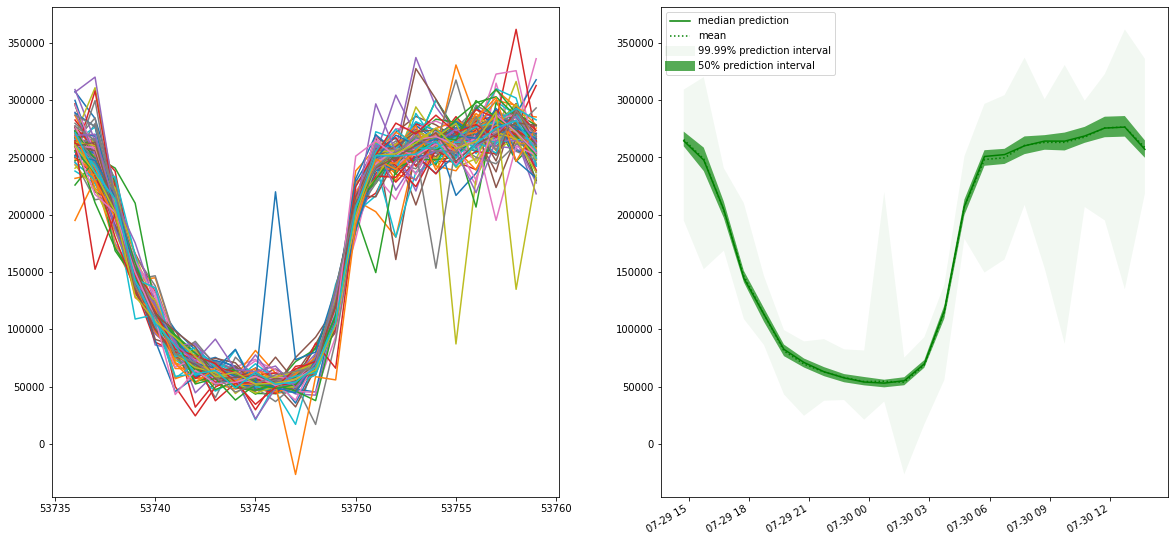

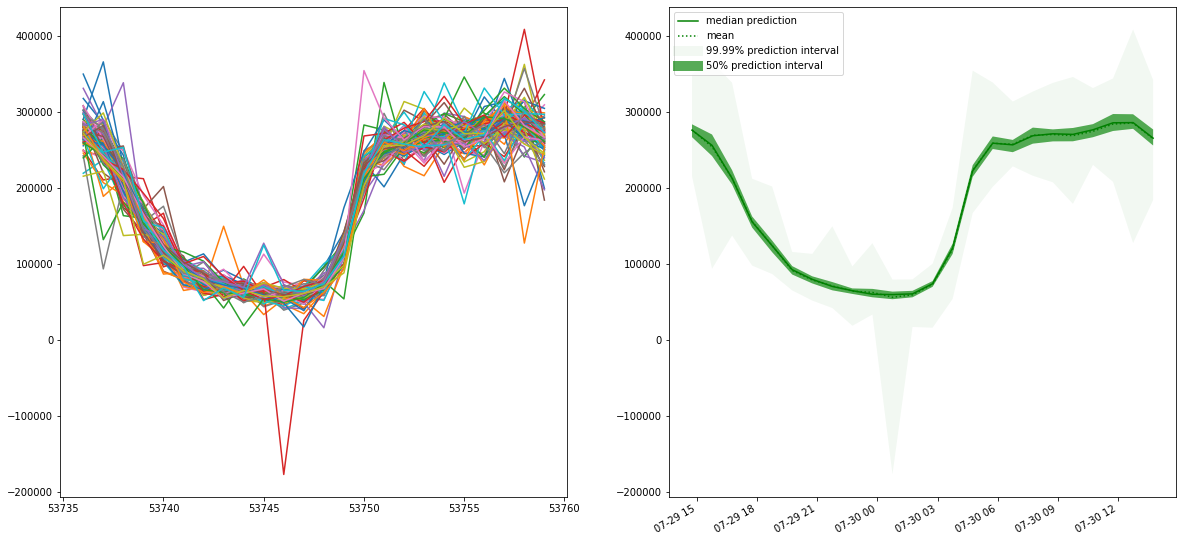

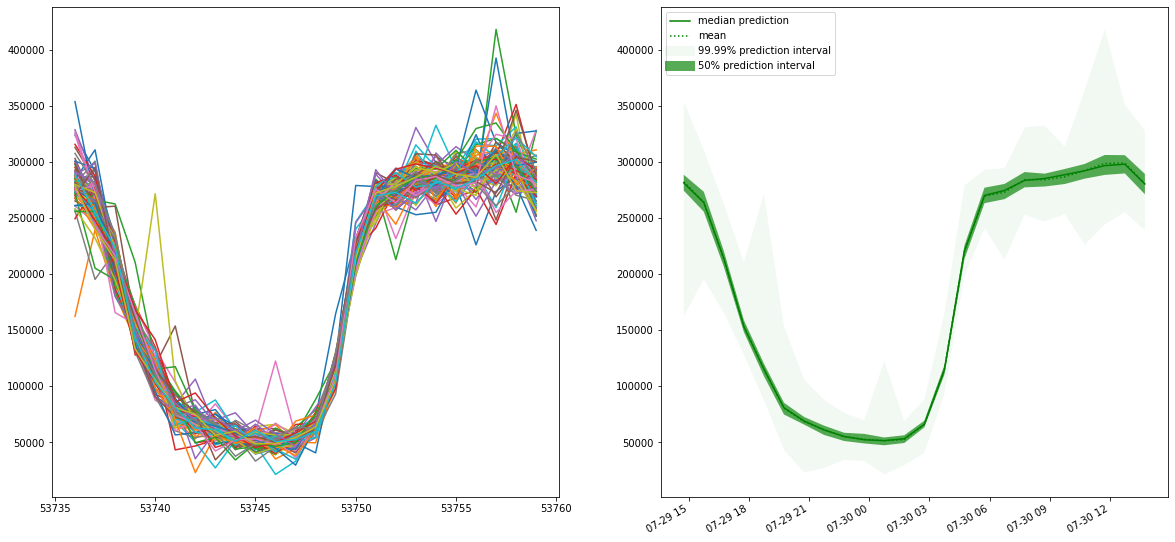

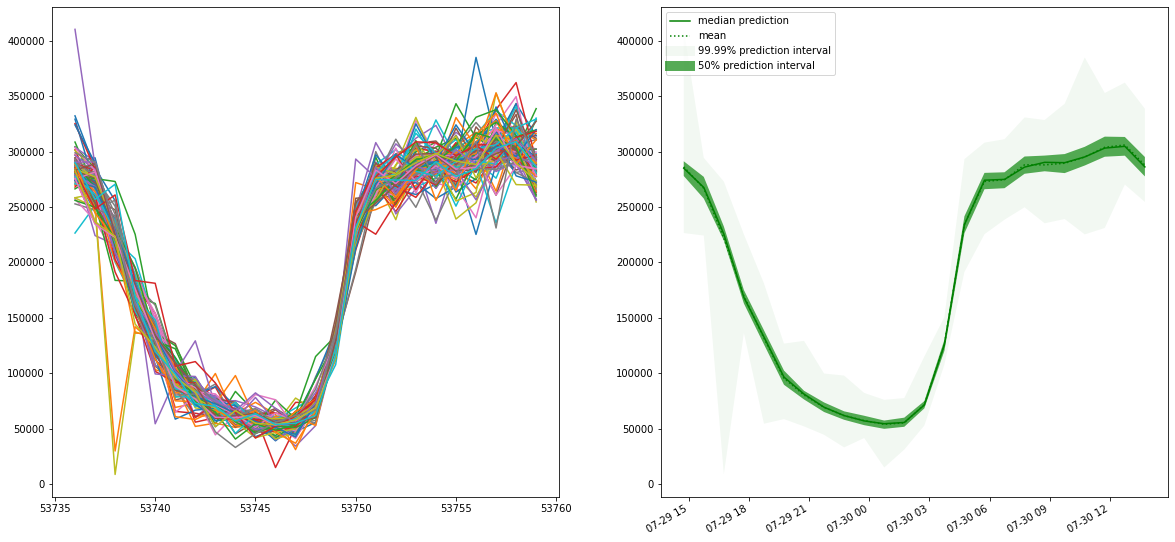

In [87]:
tmp_n = 53736
save_plot_exp(10, tmp_n)

# 50% interval

### I want values between quantile 0.25 and 0.75 percent in my dataset

In [88]:
sample_forcast_list[0]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
sample0,14.379720,11.616039,17.561302,24.004303,18.771730,20.312325,21.459580,22.115059,22.725494,24.404095,...,3408.1184,3759.9140,3618.0034,3362.8606,3411.2124,4066.0178,3844.4490,3932.6667,2425.3064,3405.9153
sample1,17.195013,26.078800,20.301533,21.817753,23.281832,19.998745,16.863081,23.405290,24.261312,47.478947,...,3444.2990,3287.6626,3331.0970,3591.5090,3761.8674,3712.7520,3338.7993,3530.4812,3588.4521,3210.2870
sample2,16.816391,21.088438,19.986979,22.116865,22.229113,26.031810,23.707888,23.367422,20.343147,8.893280,...,3339.6690,3812.4983,3678.6233,3817.3765,3806.9119,3770.0610,3266.0083,3617.7220,3477.5203,3182.5225
sample3,15.426297,18.665880,20.580153,23.141403,22.790546,23.731490,21.891476,24.997192,23.367510,18.879694,...,3432.6882,3657.4570,3670.8794,3624.2625,3461.4426,3734.4520,3494.7974,3522.9685,3585.2444,3560.1904
sample4,15.173604,23.618174,30.532934,25.938190,23.521881,23.635962,20.457691,27.114605,22.730186,23.462740,...,3643.1138,3311.5684,3577.6096,3537.3958,3534.1968,3869.1630,3872.8179,3852.6926,3879.6248,3374.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,11.198023,19.059963,12.375492,21.178700,22.414312,22.261217,21.918068,21.585732,24.703676,22.924610,...,3018.1310,3359.5176,3406.8262,3628.7104,3370.5579,3478.3875,3928.0195,3670.4930,3508.7998,3460.6663
sample96,17.758795,24.776709,18.558569,24.110640,22.177675,21.200571,21.345118,27.829294,18.730286,14.706315,...,3188.7727,3238.4336,3290.6106,3358.4546,3152.2263,3553.5940,3748.1262,3536.4768,3610.4976,3387.1467
sample97,16.044125,18.216288,20.252241,22.964743,20.309752,22.060461,26.719416,21.965384,21.311255,19.750475,...,3275.0583,3374.2007,3625.7039,3318.7456,3533.9731,3590.5808,3940.9727,3772.5212,3631.6562,3339.9790
sample98,7.908178,20.053026,6.758836,21.839102,18.221664,21.016320,22.907060,17.935090,21.467836,22.911772,...,3342.6125,2249.2913,3463.4194,3174.4130,3466.1526,3700.0361,3694.1710,3666.0256,3541.6296,3463.9866


In [89]:
sample_forcast_list[1]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
sample0,15.892927,11.395522,15.177665,26.110151,18.620432,21.956347,21.372404,21.221077,20.921910,24.583887,...,3154.1950,3408.1680,3400.9988,3137.3190,3279.8604,3556.1282,3568.2395,3807.3909,3134.3943,3577.3254
sample1,18.794500,27.619148,23.064526,23.727999,24.962437,23.470552,20.012173,25.044437,21.436140,30.642399,...,3146.7570,3006.0334,2957.1010,3439.2852,3561.8920,3495.1875,3379.6775,3334.6392,3386.8804,3045.6453
sample2,18.420332,22.450666,21.949125,24.061516,23.973990,27.150800,23.046930,21.795729,-3.070129,14.118788,...,3161.8672,3665.9673,3510.2112,3475.5776,3466.5515,3573.7668,3231.0483,3423.6538,3290.9592,2966.7727
sample3,17.061580,19.784697,20.139013,25.099686,24.638863,25.124280,21.389770,21.861984,21.013136,16.433744,...,3157.9167,3596.1738,3538.1180,3564.3140,3342.3545,3583.2370,3156.9407,3244.1711,3354.6675,3275.6343
sample4,16.810068,25.118587,27.152613,27.715292,24.656963,24.754122,18.304007,23.549688,18.144194,21.392670,...,4051.1930,3189.1118,3420.2253,3444.8804,3380.8430,3648.9456,3719.4358,3672.5344,3618.2195,3188.8103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,12.436837,20.266450,12.186051,21.407972,24.447186,21.207909,21.656654,20.490246,21.766104,21.347977,...,2640.1350,3125.8706,2463.0693,3295.9626,2935.7210,3087.7346,4311.6350,3591.3044,3336.4778,3256.6829
sample96,19.485350,26.451650,19.875664,29.472853,24.322067,23.273083,20.825693,27.825476,-1.083468,16.531591,...,1542.0083,2816.6929,3126.6838,3115.7961,2489.3840,3269.8362,3540.0520,3327.5828,3406.8933,3192.2722
sample97,17.657587,19.307308,21.870230,25.108520,21.877022,23.590380,25.054426,20.728857,18.034306,19.301868,...,3111.2693,3184.6865,3441.0847,3215.0027,3366.2202,3345.9739,3714.1714,3531.7026,3408.9020,3136.7705
sample98,9.404883,21.205408,3.637726,23.119095,20.161253,23.700909,22.962574,18.717290,20.440153,21.214708,...,3179.2712,2871.0342,3407.5747,3141.2097,3411.9653,3777.0183,3539.6016,3412.2317,3326.4695,3289.9075


In [90]:
quant_list = make_50ps_interval_list(sample_forcast_list, 2)

In [91]:
quant_list[0]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
sample0,14.379720,NaN,NaN,24.004303,NaN,NaN,21.459580,22.115059,22.725494,NaN,...,NaN,NaN,3618.0034,NaN,NaN,NaN,3844.4490,NaN,NaN,3405.9153
sample1,NaN,NaN,20.301533,21.817753,23.281832,NaN,NaN,23.405290,24.261312,NaN,...,NaN,3287.6626,NaN,3591.5090,NaN,3712.7520,NaN,NaN,3588.4521,NaN
sample2,16.816391,21.088438,19.986979,22.116865,22.229113,NaN,23.707888,23.367422,NaN,NaN,...,3339.6690,NaN,NaN,NaN,NaN,3770.0610,NaN,3617.7220,NaN,NaN
sample3,15.426297,NaN,20.580153,23.141403,22.790546,23.731490,21.891476,NaN,23.367510,NaN,...,NaN,NaN,NaN,NaN,3461.4426,3734.4520,NaN,NaN,3585.2444,3560.1904
sample4,15.173604,23.618174,NaN,NaN,23.521881,23.635962,20.457691,NaN,22.730186,23.462740,...,NaN,3311.5684,3577.6096,3537.3958,3534.1968,NaN,NaN,3852.6926,NaN,3374.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample95,NaN,NaN,NaN,NaN,22.414312,22.261217,21.918068,21.585732,24.703676,22.924610,...,NaN,3359.5176,3406.8262,NaN,NaN,NaN,NaN,3670.4930,NaN,3460.6663
sample96,NaN,24.776709,NaN,24.110640,22.177675,NaN,21.345118,NaN,NaN,NaN,...,3188.7727,NaN,NaN,NaN,NaN,NaN,3748.1262,NaN,3610.4976,3387.1467
sample97,16.044125,NaN,20.252241,22.964743,NaN,22.060461,NaN,21.965384,21.311255,19.750475,...,3275.0583,3374.2007,3625.7039,NaN,3533.9731,3590.5808,NaN,3772.5212,3631.6562,3339.9790
sample98,NaN,20.053026,NaN,21.839102,NaN,NaN,22.907060,NaN,21.467836,22.911772,...,3342.6125,NaN,3463.4194,NaN,3466.1526,3700.0361,3694.1710,3666.0256,3541.6296,3463.9866


In [93]:
quant_samples = get_forcast_distrib_sample(quant_list)
quant_samples[1]

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
mean,17.050556,24.034083,23.265694,25.367783,24.947864,24.920051,21.434539,20.391802,20.737153,20.269498,...,3094.895886,3211.195640,3353.052136,3303.034332,3367.555080,3447.928606,3543.882278,3499.014944,3404.428108,3218.308888
sigma,1.083728,1.939514,1.532355,0.954736,0.612055,0.788701,0.875960,1.035062,0.844321,0.842185,...,60.752462,92.225312,75.026571,70.309583,56.588791,59.350773,71.694807,99.706573,67.605372,71.387254


In [94]:
# convert the list of dataframes to a 3d np
forcast_np_quant = get_np_forcast(quant_samples)
forcast_np_quant.shape

(2, 2, 53928)

In [95]:
# get std over different runs
forcast_std_np = get_std_np(forcast_np_quant, quant_samples)
forcast_std_pd = pd.DataFrame(forcast_std_np)
forcast_std_pd

,0,1,2,3,4,5,6,7,8,9,...,53918,53919,53920,53921,53922,53923,53924,53925,53926,53927
0,0.797896,0.702003,0.848294,1.074589,0.833722,0.707457,0.148247,0.846456,1.237628,0.850556,...,90.740775,99.708410,91.835564,102.457523,94.393708,105.591381,96.462560,117.171675,109.828029,119.536694
1,0.004241,0.044856,0.013443,0.085610,0.057486,0.104678,0.166476,0.107204,0.192228,0.235112,...,0.482591,1.041675,0.257859,3.179281,0.272755,1.960970,4.332335,1.683198,0.846637,1.769153


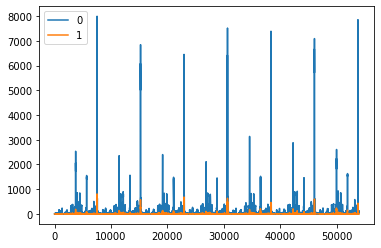

In [96]:
forcast_std_pd.T.plot()

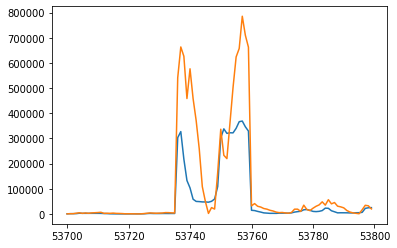

In [97]:
i = 0
target_forcast_series[(53700 - i*7704):(53800 - i*7704)].plot()
(forcast_std_pd.loc[0][(53700 - i*7704):(53800 - i*7704)] * 100).plot()

### non_modular

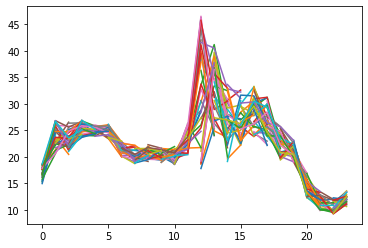

In [100]:
# took more than 10 mins 
sample_n = 0
quant_list[1].iloc[:, sample_n : sample_n + 24].T.plot(legend=False)

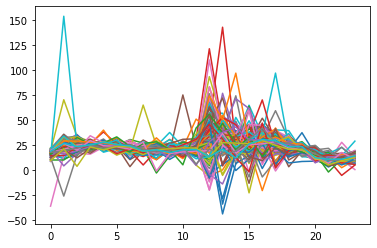

In [101]:
sample_forcast_list[1].iloc[:, sample_n : sample_n + 24].T.plot(legend=False)

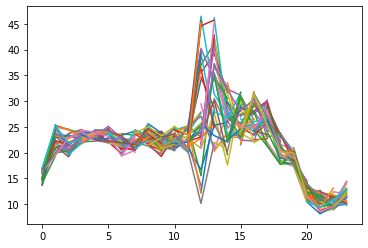

In [102]:
quant_list[0].iloc[:, sample_n : sample_n + 24].T.plot(legend=False)

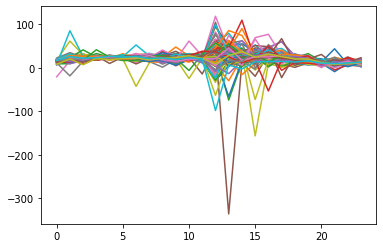

In [103]:
sample_forcast_list[0].iloc[:, sample_n : sample_n + 24].T.plot(legend=False)

# KS test

In [105]:
from scipy import stats
np.random.seed(12345678)  #fix random seed to get the same result
n1 = 200  # size of first sample
n2 = 300  # size of second sample

In [106]:
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5)
rvs3 = stats.norm.rvs(size=n2, loc=0.01, scale=1.0)
stats.ks_2samp(rvs1, rvs1)

Ks_2sampResult(statistic=0.0, pvalue=1.0)

In [107]:
exp_n = 5
data_n_el = 4
smpl0 = sample_forcast_list[exp_n][data_n_el]

exp_n = 6
smpl2 = sample_forcast_list[exp_n][data_n_el]

exp_n = 0
smpl3 = sample_forcast_list[exp_n][data_n_el]

# stats.ks_2samp(smpl1, smpl1)
# smpl1 = smpl1.to_numpy()
# smpl2 = smpl2.to_numpy()

In [108]:
stats.ks_2samp(smpl2, smpl0)

Ks_2sampResult(statistic=0.39, pvalue=3.5690338557186834e-07)

In [109]:
stats.ks_2samp(smpl2, smpl3)

Ks_2sampResult(statistic=0.11, pvalue=0.5830090612540064)

In [110]:
res = stats.ks_2samp(rvs1, smpl0)
res.pvalue

2.4836996449564004e-58

### as it is possible smpl 0 and 2 are not for the same distribution, however 2 and 3 are

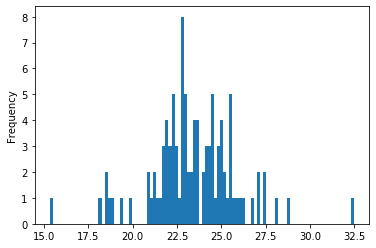

In [111]:
smpl2.plot.hist(bins = 100)

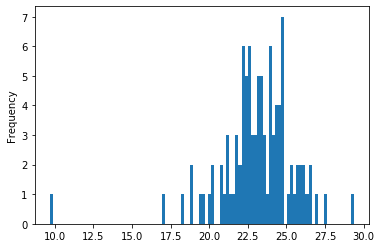

In [112]:
smpl3.plot.hist(bins = 100)

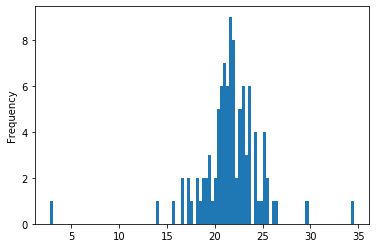

In [113]:
smpl0.plot.hist(bins = 100)

In [114]:
### TODO: get the table of ks test
### get only from 25 tp 75 (50% interval)

## Get pvalue and statistic of ks test for all of the time points in all of the experiments
them we can use this table as a mask for evaluation

In [115]:
exp_lim = 10
# timepoint_lim = 53928 for now I will chekc only 100 first timepoints
timepoint_lim = 100

# initialze the tables with 0
ks_statistic_table = np.zeros((timepoint_lim, exp_lim, exp_lim))
ks_pvalue_table = np.zeros((timepoint_lim, exp_lim, exp_lim))



# for all the experiments,
for timepoint_el in tqdm(range(timepoint_lim)):
    for exp_n in range(exp_lim):
        for idx in range(exp_n,exp_lim):
            smpl1 = sample_forcast_list[exp_n][timepoint_el]
            smpl2 = sample_forcast_list[idx][timepoint_el]
            res = stats.ks_2samp(smpl1, smpl2)
            ks_statistic_table[timepoint_el,exp_n,idx] = res.statistic
            ks_pvalue_table[timepoint_el,exp_n,idx] = res.pvalue
        
pd.DataFrame(ks_pvalue_table[4]) > 0.05

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 126.72it/s]


,0,1,2,3,4,5,6,7,8,9
0,True,False,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,True,False,False
3,False,False,False,True,False,True,False,False,True,False
4,False,False,False,False,True,False,False,False,False,False
5,False,False,False,False,False,True,False,False,True,False
6,False,False,False,False,False,False,True,False,False,False
7,False,False,False,False,False,False,False,True,False,False
8,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,False,False,False,True


In [116]:
exp_lim = 10
# timepoint_lim = 53928 for now I will chekc only 100 first timepoints
timepoint_lim = 100

ks_stat, ks_pval = kss_test(sample_forcast_list, exp_lim, timepoint_el)
pd.DataFrame(ks_pval[0])

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 140.13it/s]


,0,1,2,3,4,5,6,7,8,9
0,1.0,0.000738,0.815415,1.752719e-06,1.605714e-05,2.248739e-04,0.111195,2.219936e-03,0.015577,1.115168e-08
1,0.0,1.000000,0.000008,4.528308e-17,2.458151e-15,2.359168e-10,0.000120,6.617358e-08,0.000008,4.117410e-04
2,0.0,0.000000,1.000000,1.752719e-06,1.605714e-05,6.281177e-05,0.078221,1.293506e-03,0.006134,1.002465e-11
3,0.0,0.000000,0.000000,1.000000e+00,9.684099e-01,1.548387e-01,0.000063,1.557713e-02,0.002220,1.334180e-21
4,0.0,0.000000,0.000000,0.000000e+00,1.000000e+00,7.822116e-02,0.000738,1.111953e-01,0.009878,3.108080e-20
5,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.036384,7.020570e-01,0.154839,2.458151e-15
6,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,3.681878e-01,0.908411,4.414206e-09
7,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.702057,1.070076e-12
8,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000,2.359168e-10
9,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00
